# Convolutional Neural Network for Chest X-Ray images

Pneumonia is a lung disease characterized by inflammation of the airspaces in the lungs, most commonly due to an infection. In this project, you will train a CNN model to classify Pneumonia disease (Pneumonia/Normal) based on chest X-Ray images. 

The chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old. All chest X-ray imaging was performed as part of patients’ routine clinical care. Please refer to this [link](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5) for more information.

In [25]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

# record start time
_START_RUNTIME = time.time()

# set seed
seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

# Define data and weight path
DATA_PATH = "lib/data"
WEIGHT_PATH = "lib/data/weight/resnet18_weights_9.pth"

## 1 Load and Visualize the Data

The data is under `DATA_PATH`. In this part we will load the data into the data loader, and calculate some statistics.

In [26]:

def get_count_metrics(folder, data_path=DATA_PATH):
    
    '''
    Implement this function to return the number of normal and pneumonia samples.
    input
        folder: str, 'train', 'val', or 'test'
    output
        number_normal: number of normal samples in the given folder
        number_pneumonia: number of pneumonia samples in the given folder
    '''
    normal_dir = f"{data_path}/{folder}/NORMAL"
    number_normal = len([name for name in os.listdir(normal_dir)])
    
    pneumonia_dir = f"{data_path}/{folder}/PNEUMONIA"
    number_pneumonia = len([name for name in os.listdir(pneumonia_dir)])

    return number_normal, number_pneumonia



def load_data(data_path=DATA_PATH):
    
    '''
    Return the data loader for train and validation dataset.
    output
        train_loader: train data loader (type: torch.utils.data.DataLoader)
        val_loader: val data loader (type: torch.utils.data.DataLoader)
    '''

    import torchvision
    import torchvision.datasets as datasets
    import torchvision.transforms as transforms

    batch_size = 32
    
    # https://pytorch.org/docs/stable/torchvision/transforms.html
    transform = transforms.Compose([
        transforms.RandomResizedCrop(size=(224, 224)),
        transforms.ToTensor(),
    ])
    
    train_dataset = datasets.ImageFolder(root=f"{data_path}/train", transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    val_dataset = datasets.ImageFolder(root=f"{data_path}/val", transform=transform)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

In [27]:
get_count_metrics('train')

(335, 387)

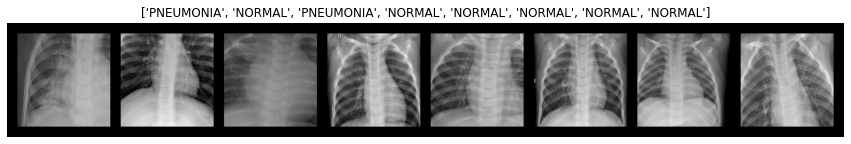

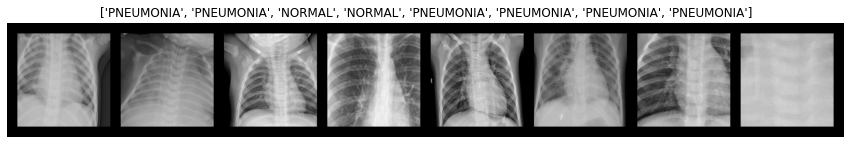

In [30]:
import torchvision
import matplotlib.pyplot as plt

def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(15, 7))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

def show_batch_images(dataloader, k=8):
    images, labels = next(iter(dataloader))
    images = images[:k]
    labels = labels[:k]
    img = torchvision.utils.make_grid(images, padding=25)
    imshow(img, title=["NORMAL" if x==0  else "PNEUMONIA" for x in labels])

train_loader, val_loader = load_data()   
for i in range(2):
    show_batch_images(train_loader)

## 2 Build the Model

Here we will define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you will use the following:
- [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
- [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most active pixels from the previous layer.
- The usual Linear + Dropout layers to avoid overfitting and produce a 2-dim output.

Below is a typical CNN architicture which consists of \[INPUT - CONV - RELU - POOL - FC\] layers.

<img src=./img/convnet.jpg>

### 2.1 Convolutional Layer Output Volume

First, we will calculate the output volume for a convolutional layer: given the input volume size $W$, the kernel/filter size $F$, the stride $S$, and the amount of zero padding $P$ used on the border, calculate the output volume size.

In [31]:
def conv_output_volume(W, F, S, P):
    
    """
    input:
        input volume size $W$
        the kernel/filter size $F$
        the stride $S$
        the amount of zero padding $P$ used on the border
    output:
        the output volume size 
    """
    return int((W - F + 2*P)/S) + 1

### 2.2 Define CNN
Now we will define our own CNN model below. Note that, the more convolutional layers we include, the more complex patterns the model can detect. For now, let's build a model including 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting.

Reference: [PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py).

In [33]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        v1 = conv_output_volume(W=224, F=self.conv1.kernel_size[0], S=self.conv1.stride[0], P=self.conv1.padding[0])
        v2 = conv_output_volume(W=v1, F=self.pool.kernel_size, S=self.pool.stride, P=self.pool.padding)
        v3 = conv_output_volume(W=v2, F=self.conv2.kernel_size[0], S=self.conv2.stride[0], P=self.conv2.padding[0])
        v4 = conv_output_volume(W=v3, F=self.pool.kernel_size, S=self.pool.stride, P=self.pool.padding)
        self.fc1 = nn.Linear(in_features=self.conv2.out_channels * v4 * v4, out_features=1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        #input is of shape (batch_size=32, 3, 224, 224)

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(input=x, start_dim=1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [34]:
simple_model = SimpleCNN()
simple_model_size = sum([param.nelement() * param.element_size() for param in simple_model.parameters()]) / 1e9
print('SimpleCNN size in GB:', simple_model_size)
assert simple_model_size <= 1, 'SimpleCNN is too large! Please minimize the number of parameters.'

SimpleCNN size in GB: 0.185157864


### 2.3 Using Predefined CNN Model
In this section, we will import a predefined CNN, the ResNet18 model, which is pretty successful in many image classification tasks. We will modify the last layer to use it on our binary classification problem, but keep the rest of the structure the same. This is called transfer learning.

In [36]:
def get_cnn_model():
    """
    We will use a ResNet18 model and set `pretrained=False`. 
    We will manually load the weights later.
    We replace the last layer (model.fc) with a nn.Linear layer. 
    The new model.fc should have the same input size but a new output_size of 2
    """
    from torchvision import models
    
    num_classes = 2
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, out_features=num_classes, bias=True)
    
    #For computation efficiency, we will freeze the weights in the bottom layers
    for param in model.named_parameters():
        if param[0].split(".")[0] == 'fc':
            continue
        param[1].requires_grad = False
    return model

## 3 Training the Network

Due to the computation environment constraint, we will load some pre-trained weights instead of training everything from scratch. 

In [38]:
model = get_cnn_model()
#Load the pretrained weights
#If it fails, it probably means you did not define the model correctly
model.load_state_dict(torch.load(WEIGHT_PATH, map_location='cpu'))

<All keys matched successfully>

### 3.1 Criterion and Opimizer
In this part, we will define the loss and optimizer for the model and then perform model training.

In [39]:
# Specify loss function (CrossEntropyLoss) and assign it to `criterion`.
criterion = nn.CrossEntropyLoss()

# Spcify optimizer (SGD) and assign it to `optimizer`.
# the learning rate is usually a small number on the scale of 1e-4 ~ 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

### 3.2 Training

Now let us train the CNN model we previously created. Steps:
- Clear the gradients of all optimized variables
- Forward pass: compute predicted outputs by passing inputs to the model
- Calculate the loss
- Backward pass: compute gradient of the loss with respect to model parameters
- Perform a single optimization step (parameter update)
- Update average training loss


In [41]:
# number of epochs to train the model
# use 1 epoch to just go through the whole process
n_epochs = 1

def train_model(model, train_dataloader, n_epoch=n_epochs, optimizer=optimizer, criterion=criterion):
    import torch.optim as optim
    """
    :param model: A CNN model
    :param train_dataloader: the DataLoader of the training data
    :param n_epoch: number of epochs to train
    :return:
        model: trained model
    """
    model.train() # prep model for training
    
    for epoch in range(n_epoch):
        curr_epoch_loss = []
        for data, target in train_dataloader:
            # zero out currently accumulated gradient
            optimizer.zero_grad()
            # pass the input through the model
            logits = model(data)
            # pass the output through loss_func to compute the loss
            loss = criterion(input=logits, target=target)
            # use loss.basckward to backprop the gradients
            loss.backward()
            optimizer.step()
            curr_epoch_loss.append(loss.cpu().data.numpy())
        print(f"Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
    return model

In [42]:
# get train and val data loader
train_loader, val_loader = load_data()

seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

model = train_model(model, train_loader)

Epoch 0: curr_epoch_loss=0.16841478645801544


## 4 Test the Trained Network

Now we will test our model on the validation data and evaluate its performance.

In [43]:
def eval_model(model, dataloader):
    """
    :return:
        Y_pred: prediction of model on the dataloder.
            Should be an 2D numpy float array where the second dimension has length 2.
        Y_test: truth labels. Should be an numpy array of ints
    """
    model.eval()
    Y_pred = []
    Y_test = []
    for data, target in dataloader:
        output = model(data)
        Y_pred.append(output.argmax(dim=1).cpu().data.numpy())
        Y_test.append(target)
    Y_pred = np.concatenate(Y_pred, axis=0)
    Y_test = np.concatenate(Y_test, axis=0)

    return Y_pred, Y_test

In [44]:
from sklearn.metrics import accuracy_score

y_pred, y_true = eval_model(model, val_loader)
acc = accuracy_score(y_true, y_pred)
print(("Validation Accuracy: " + str(acc)))

Validation Accuracy: 0.8452380952380952


In [45]:
print("Total running time = {:.2f} seconds".format(time.time() - _START_RUNTIME))

Total running time = 44.86 seconds
